# <center>Lighthill-Whitham-Richards 方程：绿灯通行</center>

## 1. 问题描述

考虑连续初值 $u_0(x)$ 对应于绿灯通行（green light）情形下的初边值问题（出流边界条件无需事先给定）
\begin{equation*}
\begin{array}{cl}
\partial_t u(x,t)+ \big( 1 - 2 u(x,t) \big) \partial_x u(x,t) = 0, & \mathrm{for}\  (x,t)\in (-1,2)\times(0,1),\\
u_0(x) = 
\left\{\begin{array}{ll}
1,& \mathrm{for}\ x<0,\\
1-x,& \mathrm{for}\ 0\leq x <1,\\
0,& \mathrm{for}\ x>1,\\
\end{array}\right. & \mathrm{for}\ x\in[-1,2], 
\end{array}
\end{equation*}
其中 $0\leq u(x,t) \leq u_{\textnormal{max}} = 1$ 代表车流密度。此时，特征线未铺满整个 $(x,t)$ 平面，并表现出稀疏波（rarefaction wave）的行为。进一步通过自相似解方法【[参考资料](https://faculty.washington.edu/rjl/riemann_book/Traffic_flow.html)】可知

$$
u(x, t) = \left\{
    \begin{array}{ll}
    1, \ \ & x < - t, \\
    \frac{1+t-x}{1+2t}, \ \ & -t < x < t+1,\\
    0, \ \ & x\geq t+1.
    \end{array}\right.
$$

## 2. 物理信息神经网络
由于稀疏波的解为连续函数，因此考虑直接用神经网络对其进行参数化，即
\begin{equation*}
	u(x,t) = \hat{u}_{\mathrm{NN}}(x,t;\theta)
\end{equation*}

进而通过方程的残量来定义损失函数

\begin{equation*}
	\begin{array}{c}
		\displaystyle L_{\textnormal{Intrr}} (\theta) = \frac{1}{N_{\textnormal{Intrr}}} \sum_{n=1}^{N_{\textnormal{Intrr}}} \big| \partial_t\hat{u}_{\mathrm{NN}}(x_n,t_n; \theta) - \big( 1 - 2\hat{u}_{\mathrm{NN}}(x_n,t_n; \theta) \big) \partial_x \hat{u}_{\mathrm{NN}}(x_n,t_n; \theta) \big|^2,\\
		\displaystyle L_{\textnormal{Initl}} (\theta) = \frac{1}{N_{\textnormal{Initl}}} \sum_{n=1}^{N_{\textnormal{Initl}}} \big|  \hat{u}_{\mathrm{NN}}(x_n, 0, \varphi(x_n, 0); \theta) - u_0(x_n) \big|^2,
    \end{array}
\end{equation*}

进而求解以下优化问题来近似得到神经网络的最优参数

\begin{equation*}
	\theta^* = \operatorname*{arg\, min}_\theta ~~ L_{\textnormal{Intrr}} (\theta) + \beta_{\textnormal{I}} L_{\textnormal{Initl}} (\theta)
\end{equation*}
其中 $\beta_I$ 为惩罚系数。

#### 自动微分

自动微分技术 **Auto Differentiation**（[`torch.autograd`](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#a-gentle-introduction-to-torch-autograd)）可以用来精确计算模型解关于输入变量的导数（即 $\partial_t\hat{u}_{\mathrm{NN}}$、$\partial_x\hat{u}_{\mathrm{NN}}$），进而用于构造损失函数。

## 3. 编程求解

#### 3-1. 准备工作 - 调用函数库

In [1]:
import torch
print("torch version =", torch.__version__)
import torch.nn as nn
import numpy as np
import os
import time
import datetime
import argparse
import scipy.io as io
import math
import shutil
from torch import optim, autograd
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from itertools import cycle

torch version = 2.4.0


#### 3-1. 准备工作 - 全连接神经网络

In [2]:
class FcBlock(nn.Module):
    """ 
        dim_in  -- dimension of each block's input data
        width   -- number of nodes in each block's hidden layer
        dim_out -- dimension of each block's output data (not the dimension of final output)  
    """
    
    def __init__(self, dim_in, width, dim_out):
        super(FcBlock, self).__init__()

        # set parameters
        self.dim_in = dim_in
        self.width = width
        self.dim_out = dim_out

        # create linear layers
        self.Linear1 = nn.Linear(dim_in, width)
        self.Linear2 = nn.Linear(width, dim_out)  
        # choose activation function = Tanh
        self.activation = nn.Tanh()      

    def forward(self, x):
        
        return self.activation(self.Linear2(self.activation(self.Linear1(x))))

class FcNet(nn.Module):
    """ 
        dim_in  -- dimension of each block's input data
        width   -- number of nodes in each block's hidden layer
        dim_out -- dimension of final output data   
    """

    def __init__(self, dim_in, width, dim_out, depth):
        super(FcNet, self).__init__()

        # set parameters
        self.dim_in = dim_in
        self.width = width
        self.dim_out = dim_out
        self.depth = depth

        # creat a list for holding all blocks/layers
        self.stack = nn.ModuleList()
                
        # input layer       
        self.stack.append(nn.Linear(dim_in, width))
        # add hidden blocks
        for i in range(depth):
            self.stack.append(FcBlock(width, width, width))        
        # output layer
        self.stack.append(nn.Linear(width, dim_out))  
        
    def forward(self, x):
        
        for layer in self.stack:
            x = layer(x)

        return x   

    def Xavier_initi(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()    

#### 3-1. 准备工作 - 训练和测试数据集

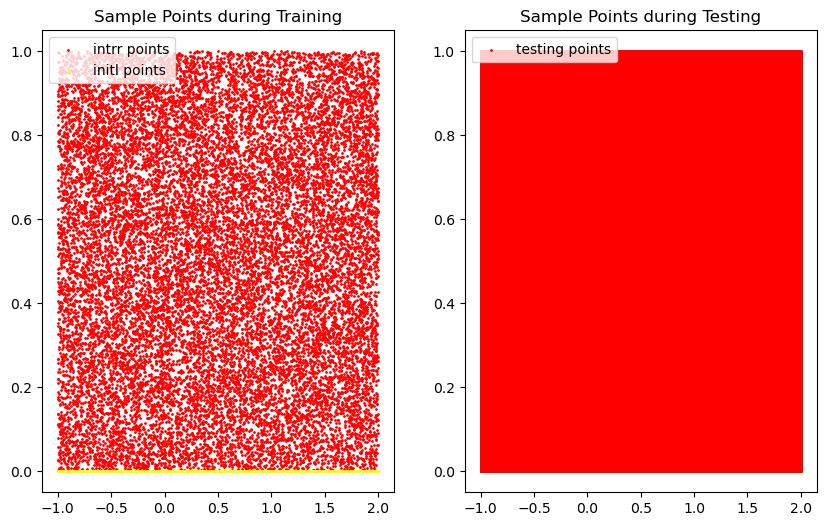

In [3]:
# computational domain
x_min, x_max = -1, 2
t_min, t_max = 0, 1

# number of collocation points for each part
traindata_size_intrr = 10000
traindata_size_initl = 2001
testdata_size_T = 1001
testdata_size_X = 1001

# generate testing points over the entire domain 
x = torch.linspace(x_min, x_max, testdata_size_X)
t = torch.linspace(t_min, t_max, testdata_size_T)
X, T = torch.meshgrid(x, t, indexing="ij") 
testdata = torch.squeeze(torch.stack([X.reshape(1,testdata_size_T*testdata_size_X), T.reshape(1,testdata_size_T*testdata_size_X)], dim=-1))   

# generate training points for each part 
def SmpPts_Interior(num_intrr_pts):    
    """ num_intrr_pts = total number of sampling points inside the domain
        dim_prob  = dimension of sampling domain """
    
    # domain (-1,2) * (0,1)                
    temp0 = torch.rand(num_intrr_pts * 2, 1) * 3 - 1 
    temp1 = torch.rand(num_intrr_pts * 2, 1)
    X_intrr = torch.cat([temp0, temp1], dim=1)
    
    return X_intrr

def SmpPts_Initial(num_initl_pts):
    ''' num_initl_pts = total number of sampling points at initial time'''
    
    temp0 = torch.zeros(num_initl_pts, 1)
    X_initl = torch.cat([torch.rand(num_initl_pts, 1) * 3 -1, temp0], dim=1)
    
    return X_initl

smppts_intrr = SmpPts_Interior(traindata_size_intrr)
smppts_initl = SmpPts_Initial(traindata_size_initl)

fig = plt.figure(figsize=(10, 6), dpi= 100)
plt.subplot(1, 2, 1)
plt.scatter(smppts_intrr[:,0], smppts_intrr[:,1], c = 'red', label = 'intrr points', s=1)
plt.scatter(smppts_initl[:,0], smppts_initl[:,1], c = 'yellow', label = 'initl points', s=1)
plt.title('Sample Points during Training')
plt.legend(loc = 'upper left')

plt.subplot(1, 2, 2)
plt.scatter(testdata[:,0], testdata[:,1], c = 'red', label = 'testing points', s=1)
plt.title('Sample Points during Testing')
plt.legend(loc = 'upper left')
plt.show()

#### 3-1. 准备工作 - 升维函数在样本点处的值

In [4]:
# initial value and exact solution
def u_Exact_Initial(x):
    
    u0 = 1 - x
    mask_leq0 = x < 0 
    u0[mask_leq0] = 1
    mask_geq1 = x > 1 
    u0[mask_geq1] = 0
    
    return u0

def u_Exact_Solution(x, t):
    
    u = (1 + t - x) / (1+2*t)
    mask_rfctT = x < -t 
    u[mask_rfctT] = 1
    mask_rfctL = x > t+1 
    u[mask_rfctL] = 0
    
    return u

#### 3-2. 网络训练

Done in 0:04:05.875697 !


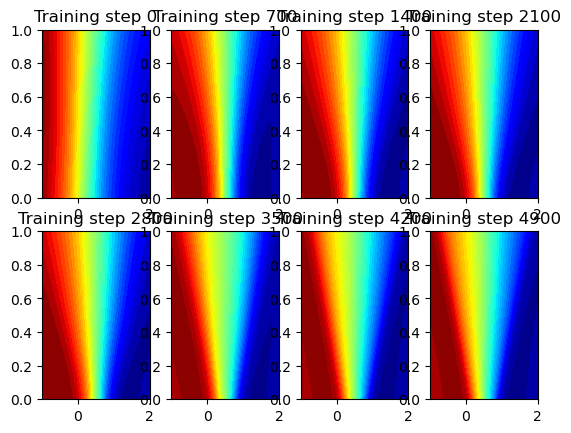

In [5]:
# penalty coefficient
beta = 400
# for decay of learning rate
milestones = [2500, 4000, 5000]

model = FcNet(2, 50, 1, 3)
model.Xavier_initi()

# create optimizer and learning rate schedular
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.05, amsgrad=False)
schedular = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)

since = time.time()
for i in range(5501):

    # enable computing gradients through autograd
    smppts_intrr.requires_grad = True 

    # compute values of initial condition
    u0_smppts = u_Exact_Initial(smppts_initl[:, 0])
    
    u_NN_intrr = model(smppts_intrr)
    u_NN_initl = model(smppts_initl)

    # zero parameter gradients and then compute NN prediction of gradient u(x)
    model.zero_grad()
    gradu_NN_intrr = torch.autograd.grad(outputs=u_NN_intrr, inputs=smppts_intrr, grad_outputs=torch.ones_like(u_NN_intrr), retain_graph=True, create_graph=True, only_inputs=True)[0]

    # construct mini-batch loss function and then perform backward pass
    loss_intrr = torch.mean(torch.pow(gradu_NN_intrr[:,1] + (1-2*torch.squeeze(u_NN_intrr)) * gradu_NN_intrr[:,0], 2))
    loss_initl = torch.mean(torch.pow(torch.squeeze(u_NN_initl) - u0_smppts, 2))

    loss_minibatch = loss_intrr + beta * loss_initl

    #zero parameter gradients
    optimizer.zero_grad()
    # backpropagation
    loss_minibatch.backward()
    # network parameter update
    optimizer.step()

    # plot the result as training progresses
    list_of_plots = []
    plt.rcdefaults()

    if i % 700 == 0: 
        ax = plt.subplot(2, 4, i // 700 + 1)
        
        u_test = model(testdata).detach()
        u_test = u_test.reshape(testdata_size_X, testdata_size_T)    

        ax.contourf(X, T, u_test, 40, cmap = 'jet')        
        ax.set_title(f"Training step {i}")
        
        list_of_plots.append(ax)
    
time_elapsed = time.time() - since
print('Done in {}'.format(str(datetime.timedelta(seconds=time_elapsed))), '!')

#### 3-3. 展示计算结果

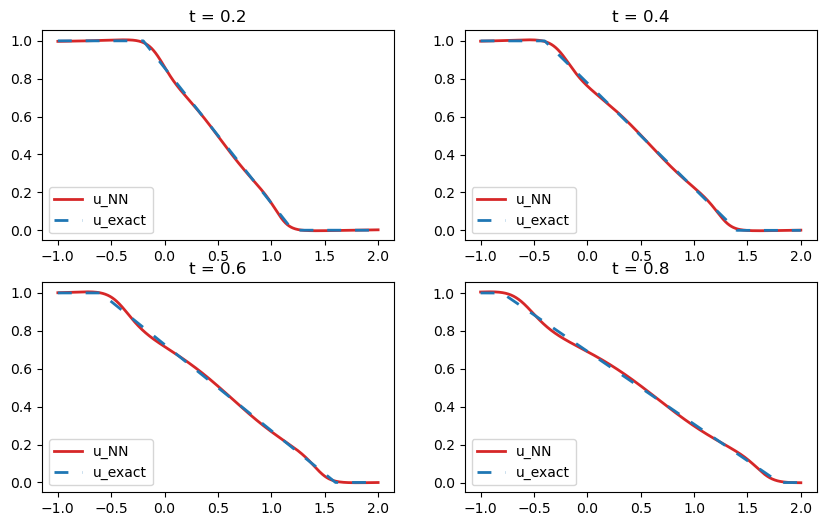

In [6]:
x = torch.linspace(x_min, x_max, steps = 1001)
t = torch.ones(x.size())

# plot the solution at t = 0.2
u_exact = u_Exact_Solution(x, 0.2 * t)
test_smppts = torch.cat([x.reshape(-1, 1), 0.2 * t.reshape(-1, 1)], dim=1)
u_pred = model(test_smppts)

fig = plt.figure(figsize=(10, 6), dpi= 100)
plt.subplot(2, 2, 1)
plt.plot(x, u_pred.detach(), linewidth=2.0, label="u_NN", color="tab:red")
plt.plot(x, u_exact, linestyle='dashed', dashes=(5, 5), linewidth=2.0, label="u_exact", color="tab:blue")
plt.title('t = 0.2')
plt.legend(loc = 'lower left')

# plot the solution at t = 0.4
u_exact = u_Exact_Solution(x, 0.4 * t)
test_smppts = torch.cat([x.reshape(-1, 1), 0.4 * t.reshape(-1, 1)], dim=1)
u_pred = model(test_smppts)

plt.subplot(2, 2, 2)
plt.plot(x, u_pred.detach(), linewidth=2.0, label="u_NN", color="tab:red")
plt.plot(x, u_exact, linestyle='dashed', dashes=(5, 5), linewidth=2.0, label="u_exact", color="tab:blue")
plt.title('t = 0.4')
plt.legend(loc = 'lower left')

# plot the solution at t = 0.6
u_exact = u_Exact_Solution(x, 0.6 * t)
test_smppts = torch.cat([x.reshape(-1, 1), 0.6 * t.reshape(-1, 1)], dim=1)
u_pred = model(test_smppts)

plt.subplot(2, 2, 3)
plt.plot(x, u_pred.detach(), linewidth=2.0, label="u_NN", color="tab:red")
plt.plot(x, u_exact, linestyle='dashed', dashes=(5, 5), linewidth=2.0, label="u_exact", color="tab:blue")
plt.title('t = 0.6')
plt.legend(loc = 'lower left')

# plot the solution at t = 0.8
u_exact = u_Exact_Solution(x, 0.8 * t)
test_smppts = torch.cat([x.reshape(-1, 1), 0.8 * t.reshape(-1, 1)], dim=1)
u_pred = model(test_smppts)

plt.subplot(2, 2, 4)
plt.plot(x, u_pred.detach(), linewidth=2.0, label="u_NN", color="tab:red")
plt.plot(x, u_exact, linestyle='dashed', dashes=(5, 5), linewidth=2.0, label="u_exact", color="tab:blue")
plt.title('t = 0.8')
plt.legend(loc = 'lower left')